# Visualise the total number of newspaper articles in Trove by year and state

Trove currently includes more 200 million digitised newspaper articles published between 1803 and 2015. In this notebook we explore how those newspaper articles are distributed over time, and by state.

1. [Setting things up](#1.-Setting-things-up)
2. [Show the total number of articles per year](#2.-Show-the-total-number-of-articles-per-year)
3. [Show the number of newspaper articles by state](#3.-Show-the-number-of-newspaper-articles-by-state)
4. [Show the number of articles by state and year](#4.-Show-the-number-of-articles-by-state-and-year)
5. [Combine everything and make it interactive!](#5.-Combine-everything-and-make-it-interactive!)
6. [Further reading](#6.-Further-reading)

If you want to skip to the final visualisation without running any of the notebook code, here's [an HTML version to play with](https://glam-workbench.github.io/trove-newspapers/trove-newspaper-articles-by-state-and-year.html). But come back here to find out how to DIY!

<div class="alert alert-block alert-warning">
<p>If you haven't used one of these notebooks before, they're basically web pages in which you can write, edit, and run live code. They're meant to encourage experimentation, so don't feel nervous. Just try running a few cells and see what happens!</p>

<p>
    Some tips:
    <ul>
        <li>Code cells have boxes around them.</li>
        <li>To run a code cell click on the cell and then hit <b>Shift+Enter</b>. The <b>Shift+Enter</b> combo will also move you to the next cell, so it's a quick way to work through the notebook.</li>
        <li>While a cell is running a <b>*</b> appears in the square brackets next to the cell. Once the cell has finished running the asterix will be replaced with a number.</li>
        <li>In most cases you'll want to start from the top of notebook and work your way down running each cell in turn. Later cells might depend on the results of earlier ones.</li>
        <li>To edit a code cell, just click on it and type stuff. Remember to run the cell once you've finished editing.</li>
    </ul>
</p>

<p><b>Is this thing on?</b> If you can't edit or run any of the code cells, you might be viewing a static (read only) version of this notebook. Click here to <a href="https://mybinder.org/v2/gh/GLAM-Workbench/trove-newspapers/master?filepath=visualise-total-newspaper-articles-by-state-year.ipynb">load a <b>live</b> version</a> running on Binder.</p>
</div>

## 1. Setting things up

### Import what we need

In [1]:
import requests
import os
from operator import itemgetter # used for sorting
import pandas as pd # makes manipulating the data easier
import altair as alt
from requests.adapters import HTTPAdapter
from requests.packages.urllib3.util.retry import Retry
from tqdm.auto import tqdm
from IPython.display import display, HTML, clear_output
import time

# Make sure data directory exists
os.makedirs('docs', exist_ok=True)

# Create a session that will automatically retry on server errors
s = requests.Session()
retries = Retry(total=5, backoff_factor=1, status_forcelist=[ 502, 503, 504 ])
s.mount('http://', HTTPAdapter(max_retries=retries))
s.mount('https://', HTTPAdapter(max_retries=retries))

alt.data_transformers.enable('json')

DataTransformerRegistry.enable('json')

The next cell sets the renderer for Altair. If you're using the classic Jupyter notebook, just run the cell as normal. If you're using Jupyter Lab, don't run it!

In [13]:
# Are you using Jupyter Lab?
# If so either don't run this cell or comment out the line below

alt.renderers.enable('notebook')

# If you forget, run this cell, and then get strange warnings when you make a chart,
# uncomment the following line and run this cell to reset the chart renderer

# alt.renderers.enable('default')

RendererRegistry.enable('default')

### Enter a Trove API key

We're going to get our data from the Trove API. You'll need to get your own [Trove API key](http://help.nla.gov.au/trove/building-with-trove/api) and enter it below.

In [27]:
# Enter your won Trove API below between the quotes
api_key = 'YOUR API KEY'

print('Your API key is: {}'.format(api_key))

Your API key is: YOUR API KEY


### Set some default parameters

In [4]:
# Basic parameters to send to the Trove API, we'll add more later.
params = {
    'zone': 'newspaper',
    'key': api_key,
    'encoding': 'json',
    'n': 0 # We don't need any records, just the facets!
}

### Define some functions

In [5]:
def get_results(params):
    '''
    Get JSON response data from the Trove API.
    Parameters:
        params
    Returns:
        JSON formatted response data from Trove API 
    '''
    response = s.get('https://api.trove.nla.gov.au/v2/result', params=params, timeout=30)
    response.raise_for_status()
    # print(response.url) # This shows us the url that's sent to the API
    data = response.json()
    return data

## 2. Show the total number of articles per year

In [another notebook](visualise-searches-over-time.ipynb), I look at different ways of visualising Trove newspaper searches over time. In this notebook we're going to focus on showing everything. To search for everything, we set the `q` parameter to a single space.

In [6]:
# Set the q parameter to a single space to get ALL THE ARTICLES
params['q'] = ' '

Now we can find the total number of newspaper articles in Trove.

In [7]:
# Get the JSON data from the Trove API using our parameters
data = get_results(params)

# Navigate down the JSON hierarchy to find the total results
total = int(data['response']['zone'][0]['records']['total'])

# Print the results
print('There are currently {:,} articles in Trove!'.format(total))

There are currently 224,797,939 articles in Trove!


Ok, that's not all that useful. What would be more interesting is to show the total number of articles published each year. To do this we use the `decade` and `year` facets. There's more details [in this notebook](visualise-searches-over-time.ipynb) but, in short, we have to loop through the decades from 1800 to 2010, getting the total number of articles for each year within that decade.

These two functions do just that.

In [8]:
def get_facets(data):
    '''
    Loop through facets in Trove API response, saving terms and counts.
    Parameters:
        data  - JSON formatted response data from Trove API  
    Returns:
        A list of dictionaries containing: 'term', 'total_results'
    '''
    facets = []
    try:
        # The facets are buried a fair way down in the results
        # Note that if you ask for more than one facet, you'll have use the facet['name'] param to find the one you want
        # In this case there's only one facet, so we can just grab the list of terms (which are in fact the results by year)
        for term in data['response']['zone'][0]['facets']['facet']['term']:
            
            # Get the year and the number of results, and convert them to integers, before adding to our results
            facets.append({'term': term['search'], 'total_results': int(term['count'])})
            
        # Sort facets by year
        facets.sort(key=itemgetter('term'))
    except TypeError:
        pass
    return facets


def get_facet_data(params, start_decade=180, end_decade=201):
    '''
    Loop throught the decades from 'start_decade' to 'end_decade',
    getting the number of search results for each year from the year facet.
    Combine all the results into a single list.
    Parameters:
        params - parameters to send to the API
        start_decade
        end_decade
    Returns:
        A list of dictionaries containing 'year', 'total_results' for the complete 
        period between the start and end decades.
    '''
    # Create a list to hold the facets data
    facet_data = []
    
    # Loop through the decades
    for decade in tqdm(range(start_decade, end_decade + 1)):
        
        # Avoid confusion by copying the params before we change anything.
        search_params = params.copy()
        
        # Add decade value to params
        search_params['l-decade'] = decade
        
        # Get the data from the API
        data = get_results(search_params)
        
        # Get the facets from the data and add to facets_data
        facet_data += get_facets(data)
        
        # Try to avoid hitting the API rate limit - increase this if you get 403 errors
        time.sleep(0.2)
        
    # Reomve the progress bar (you can also set leave=False in tqdm, but that still leaves white space in Jupyter Lab)
    clear_output()
    return facet_data

Next we need to tell the API we want the `year` facet values. We do this by setting the `facet` value in our parameters.

In [9]:
params['facet'] = 'year'

Now it's just a matter of feeding our parameters to the `get_facet_data()` function.

In [10]:
total_facets = get_facet_data(params)

Let's convert the data to a Pandas dataframe so we can feed it to Altair, our charting program.

In [11]:
df_total = pd.DataFrame(total_facets)
df_total.head()

,term,total_results
0,1803,526
1,1804,619
2,1805,430
3,1806,367
4,1807,134


Let's display the results as a simple line chart using Altair

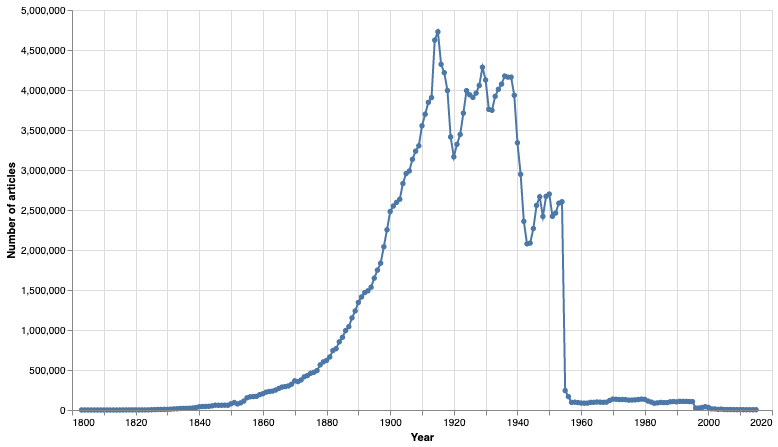

In [14]:
# Feed Altair our dataframe
alt.Chart(df_total).mark_line(point=True).encode(
    
        # Years along the X axis
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Number of articles on the Y axis (formatted with thousands separators)
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
    
        # Use tooltips to display the year and number of articles when you hover over a point
        tooltip=[alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

Hmmm, that *is* interesting. There's a significant peak in the number of articles around 1915. Why might that be? Were there more newspapers? Were more articles written because of the war?

Nope. It's because of funding and digitisation priorities. Not all Australian newspapers are in Trove. Some have been lost, and many are just waiting to be digitised. Funding is always limited, so priorities have to be set. In the lead up to the centenary of World War I, it was decided to focus on digitising newspapers from that period. This chart reflects those priorities. This is not the number of newspaper articles published in Australia, it's the number of newspaper articles that have been digitised and made available through Trove. It's important to remain aware of this as you use Trove.

But what about the dramatic drop-off in the number of articles after 1954. Was it the impact of other media technologies? Nope. It's because of copyright. Australian copyright law is complex, but it's likely that much of the material published in newspapers before 1955 is out of copyright. Therefore, in undertaking its digitisation program, the National Library decided that it could best manage the risks associated with copyright by focusing on newspapers published before 1955. You'll see, however, that there are a few exceptions. Some newspapers published after 1954 have been digitised on the basis of agreements between the publisher and the National Library. If you'd like to see what newspapers are available post-1954 have a look at [Beyond the copyright cliff of death](Beyond_the_copyright_cliff_of_death.ipynb).

## 3. Show the number of newspaper articles by state

The setting of priorities for newspaper digitisation has, in the past, been a collaborative effort between the National and State libraries. Now the focus seems to be more on a 'contributor model' where local communities or organisations fund the digitisation of their own newspapers. These sorts of arrangements obviously affect what gets digitised and when, so lets see what Trove's newspapers look like when divide them up by state.

To do this, we'll change the `facet` parameter to 'state'.

In [15]:
params['facet'] = 'state'

As we're not harvesting data for mutiple decades, we only need to make one call to the API.

In [16]:
# Get the data from the API
data = get_results(params)
facets = []

# Loop through the facet terms (each term will be a state)
for term in data['response']['zone'][0]['facets']['facet']['term']:

        # Get the state and the number of results, and convert it to integers, before adding to our results
        facets.append({'state': term['search'], 'total_results': int(term['count'])})

# Convert to a dataframe
df_states = pd.DataFrame(facets)
df_states

,state,total_results
0,New South Wales,80744141
1,Queensland,40836964
2,Victoria,37970150
3,South Australia,24320437
4,Western Australia,20556226
5,Tasmania,15416903
6,ACT,3296997
7,International,850790
8,Northern Territory,409433
9,National,395898


The first thing that's obvious is that not all 'states' are states. This facet has been expanded to incorporate 'National', and 'International' newspapers. Let's look at how the numbers in each 'state' compare.

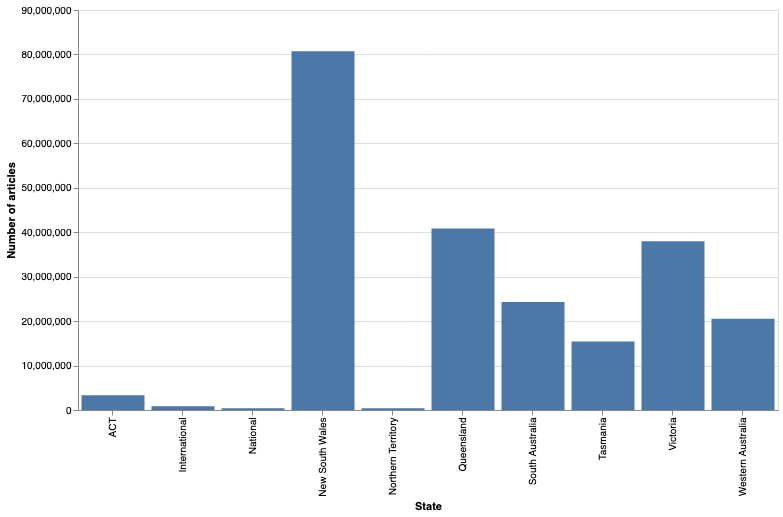

In [17]:
# Chart the results
alt.Chart(df_states).mark_bar().encode(
        x=alt.X('state:N', title='State'),
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        tooltip=[alt.Tooltip('state', title='State'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

There's almost double the number of newspaper articles from NSW as anywhere else. Why? Again, we might be tempted to think that its just because more newspapers were published in NSW. This could be true, but someone still has to pay to get them digitised. In this case, the State Library of NSW's Digital Excellence Program has supported large amounts of digitisation.

Once again, it's a reminder that digital collections are constructed. Things like priorities and funding introduce biases that are not easily visible through a standard search interface.

## 4. Show the number of articles by state and year

To look a bit further into this, let's combine the two charts above to show the number of newspaper articles for each state over time.

We'll start by setting the `facet` value back to 'year', and the `q` parameter back to a single space (for everything).

In [18]:
params['facet'] = 'year'
params['q'] = ' '

We can use the states data we just collected to get a list of possible values for the `state` facet.

In [19]:
states = df_states['state'].to_list()
states

['New South Wales',
 'Queensland',
 'Victoria',
 'South Australia',
 'Western Australia',
 'Tasmania',
 'ACT',
 'International',
 'Northern Territory',
 'National']

Now we'll define a function to loop through the list of states getting the number of articles for each year.

In [20]:
def get_state_facets(params, states):
    '''
    Loop through the supplied list of states searching getting the year by year results.
    Parameters:
        params - basic parameters to send to the API
        states - a list of states to apply using the state facet
    Returns:
        A dataframe   
    '''
    dfs = []
    these_params = params.copy()
    
    # Loop through the supplied list of states
    for state in states:
        
        # Set the state facet to the current state value
        these_params['l-state'] = state
        
        # Get year facets for this state & query
        facet_data = get_facet_data(these_params)
        
        # Convert the results to a dataframe
        df = pd.DataFrame(facet_data)
        
        # Add a state column to the dataframe and set its value to the current state
        df['state'] = state
        
        # Add this df to the list of dfs
        dfs.append(df)
        
        time.sleep(1)
    # Concatenate all the dataframes and return the result
    return pd.concat(dfs)

We're ready to get the data!

In [21]:
# GET ALL THE DATA!
df_states_years = get_state_facets(params, states)

Hmm, how are we going to visualise the results. Let's start with a stacked area chart.

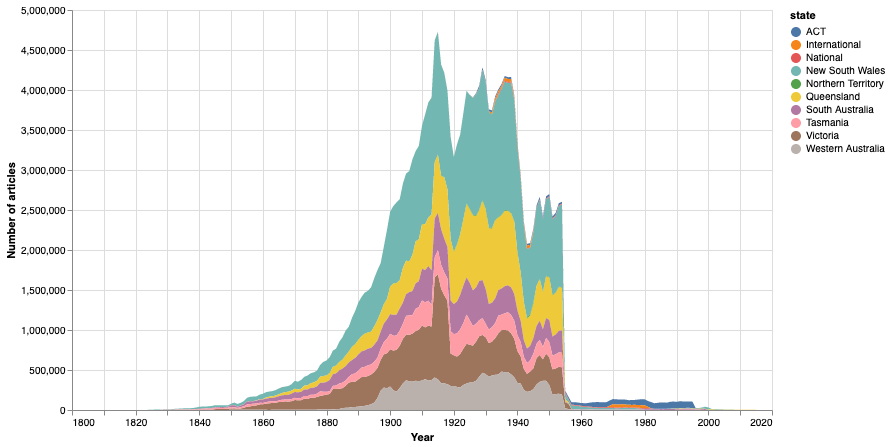

In [22]:
# Make a chart
alt.Chart(df_states_years).mark_area().encode(
    
        # Show years on the X axis
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Show the stacked number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles'), stack=True),
        
        # Use color to distinguish the states
        color='state:N',
    
        # And show the state / year / and total details on hover
        tooltip=['state', alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

That's interesting. You might notice that most of the post-1954 articles come from the ACT – through the special arrangements mentioned above, the *Canberra Times* has been digitised through to 1995. See [Beyond the copyright cliff of death](Beyond_the_copyright_cliff_of_death.ipynb) for details.

However, it's a bit hard to see the individual contributions of each state in this chart. So let's separate them out.

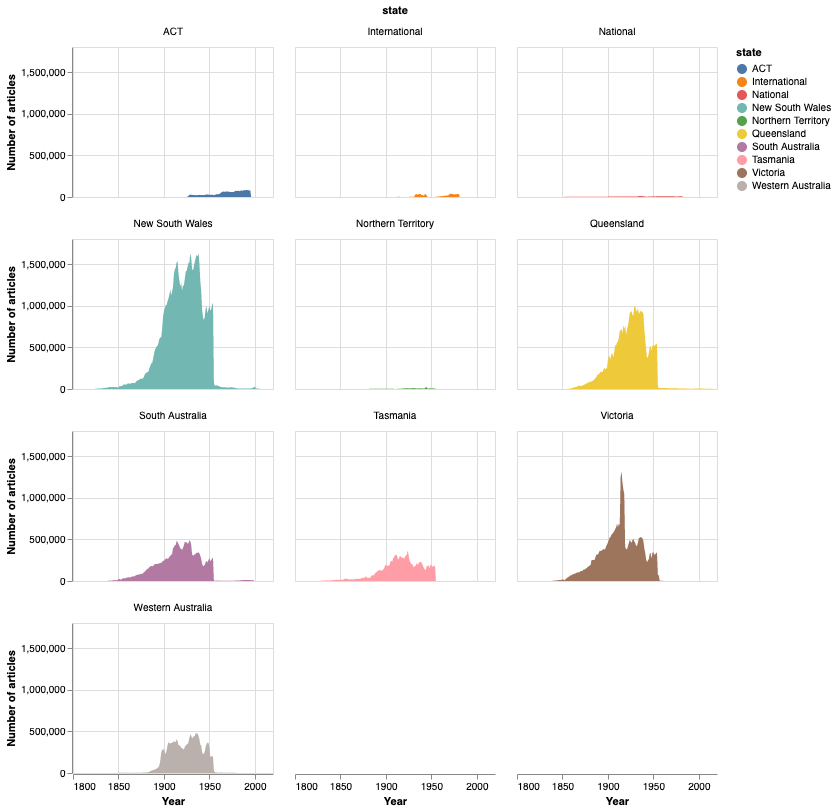

In [23]:
# A new chat that puts states in separate facets
alt.Chart(df_states_years).mark_area().encode(
    
        # Year of the X axis
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
    
        # Split the data up into sub-charts based on state
        facet='state:N',
    
        # Give each state a different color
        color='state:N',
    
        # Details on hover
        tooltip=['state', alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
        
    # Note the columns value to set the number of sub-charts in each row
    ).properties(width=200, height=150, columns=3)

Again we can see the dominance of NSW, and the post-1954 tail of ACT articles. But what's going on in Victoria? Let's zoom in for a closer look.

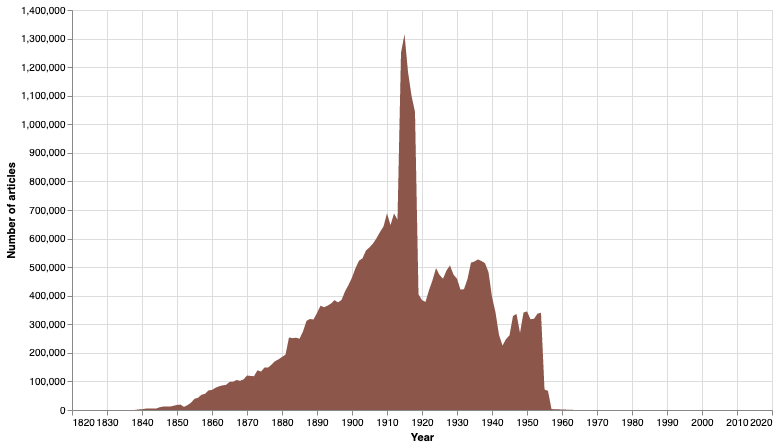

In [24]:
# Chart of Victoria only
# Filter the dataframe to just show Victoria
alt.Chart(df_states_years.loc[df_states_years['state'] == 'Victoria']).mark_area().encode(
    
        # Years on the X axis
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles'), stack=True),
    
        # Try to match the color in the chart above
        color=alt.value('#8c564b'),
    
        # Details on hover
        tooltip=[alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400)

Yikes! This is, of course, more evidence of the World War I effect. In the lead up to the centenary of WWI, Victoria decided to focus quite narrowly on the wartime period, digitising only the period between 1914 and 1919 for a [number of newspapers](https://www.slv.vic.gov.au/digitised-wwi-victorian-newspapers).

Priorities have to be set, decisions about funding have to be made. The point, once again, is that these sorts of decisions shape what you get back in your search results. To really understand what it is we're working with, we have to be prepared to look beyond the search box.

## 5. Combine everything and make it interactive!

For the sake of completeness, let's try combining everything to make an interactive chart that shows both the total number of articles per year, and the contributions of each state.

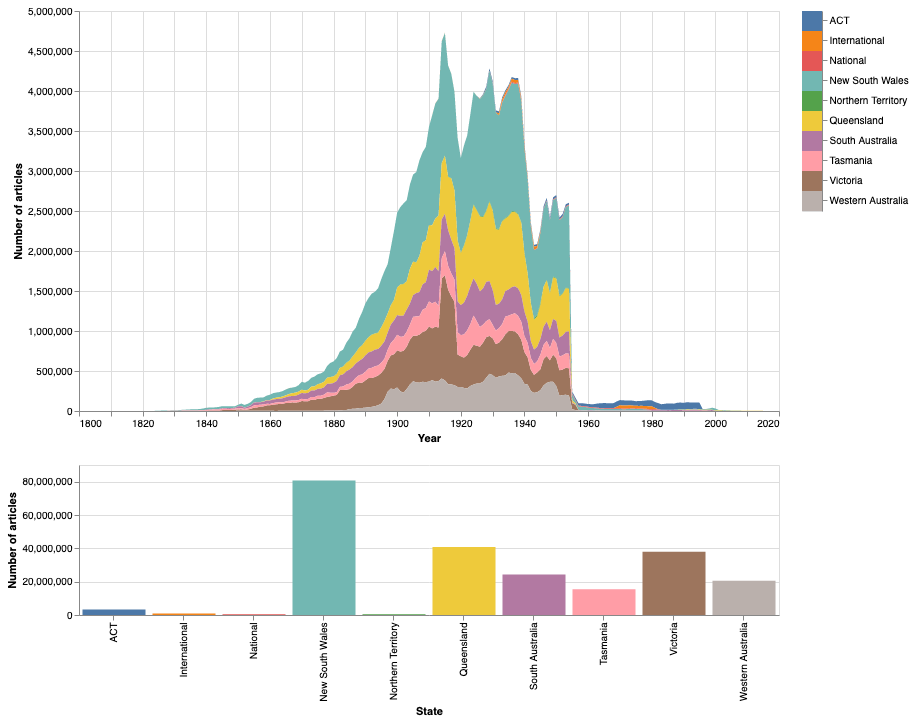

In [25]:
# Use color as the selector for filtering the chart
selection = alt.selection_multi(encodings=['color'])

# Color is based on the state, or gray if another state is selected
color = alt.condition(selection,
                      alt.Color('state:N', legend=None),
                      alt.value('lightgray'))

# A basic area chart, starts stacked, but when filtered shows only the active state
area = alt.Chart(df_states_years).mark_area().encode(
    
        # Years on the X axis
        x=alt.X('term:Q', axis=alt.Axis(format='c', title='Year')),
    
        # Number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles'), stack=True),
        
        # Color uses the settings defined above
        color=color,
    
        # Details on hover
        tooltip=['state', alt.Tooltip('term:Q', title='Year'), alt.Tooltip('total_results:Q', title='Articles', format=',')]
    ).properties(width=700, height=400).transform_filter(
        # Filter data by state when a state is selected
        selection
    ).add_selection(
        selection
    )

# Add a bar chart showing the number of articles per state
bar = alt.Chart(df_states).mark_bar().encode(
    
        # State on the X axis
        x=alt.X('state:N', title='State'),
    
        # Number of articles on the Y axis
        y=alt.Y('total_results:Q', axis=alt.Axis(format=',d', title='Number of articles')),
        
        # Details on hover
        tooltip=[alt.Tooltip('state', title='State'), alt.Tooltip('total_results:Q', title='Articles', format=',')],
        
        # Color based on state as defined above
        color=color
    ).properties(width=700, height=150).add_selection(
        # Highlight state when selected
        selection
    )

# For good measure we'll add an interactive legend (which is really just a mini chart)
# This makes it easier to select states that don't have many articles
legend = alt.Chart(df_states).mark_rect().encode(
    
    # Show the states 
    y=alt.Y('state:N', axis=alt.Axis(orient='right', title=None)),
    
    # Color as above
    color=color
    ).add_selection(
        # Highlight on selection
        selection
    )

# Concatenate the charts -- area & legend hotizontal, then bar added vertically
(area | legend) & bar

You can select a state by clicking on a colour in any of the three connected charts. To unselect, just click on an area with no color.

Let's save this chart as an HTML page, so we can share and play with it outside of this notebook.

In [26]:
combined_chart = (area | legend) & bar
combined_chart.save('docs/trove-newspaper-articles-by-state-and-year.html')

[Here's the result!](https://glam-workbench.github.io/trove-newspapers/trove-newspaper-articles-by-state-and-year.html)

## 6. Further reading

* Tim Sherratt, ['Asking better questions: history, Trove and the risks that count'](http://discontents.com.au/asking-better-questions-history-trove-and-the-risks-that-count/), in *CopyFight*, Phillipa McGuiness (ed.), NewSouth Books, 2015.

* Tim Sherratt, ['Seams and edges: dreams of aggregation, access, and discovery in a broken world'](http://discontents.com.au/seams-and-edges-dreams-of-aggregation-access-discovery-in-a-broken-world/), ALIA Online, 2015.

* Tim Sherratt, ['Hacking heritage: understanding the limits of online access'](https://hcommons.org/deposits/item/hc:18733/), preprint of a chapter submitted for publication as part of *The Routledge International Handbook of New Digital Practices in Galleries, Libraries, Archives, Museums and Heritage Sites*, forthcoming 2019.

----

Created by [Tim Sherratt](https://timsherratt.org/).

Work on this notebook was supported by the [Humanities, Arts and Social Sciences (HASS) Data Enhanced Virtual Lab](https://tinker.edu.au/).